In [1]:
# Downloads required packages and files
required_files = "https://github.com/jhu-intro-hlt/jhu-intro-hlt.github.io/raw/master/assignments/hw2-files/student/required_files.zip"
! wget $required_files && unzip -o required_files.zip
! pip install -r requirements.txt

--2025-09-24 00:04:09--  https://github.com/jhu-intro-hlt/jhu-intro-hlt.github.io/raw/master/assignments/hw2-files/student/required_files.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jhu-intro-hlt/jhu-intro-hlt.github.io/master/assignments/hw2-files/student/required_files.zip [following]
--2025-09-24 00:04:10--  https://raw.githubusercontent.com/jhu-intro-hlt/jhu-intro-hlt.github.io/master/assignments/hw2-files/student/required_files.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5364088 (5.1M) [application/zip]
Saving to: ‘required_files.zip’

required_files.zip  100%[==============

In [1]:
# Initialize Otter
import otter

grader = otter.Notebook(colab=True)

# Assignment 2

In the last few lectures, you have looked at two work-horses of natural language processing: recurrent neural networks, and word embeddings (distributional semantics). In this assignment, you will put the learning into practice by implementing some of these yourself, and doing some exploratory analysis.

# Setup

For this assignment, as in the previous one, we will be using Google Colab, for both code as well as descriptive questions. Your task is to finish all the questions in the Colab notebook and then upload a PDF version of the notebook, and a viewable link on Gradescope.

### Google colaboratory

Before getting started, get familiar with google colaboratory:
https://colab.research.google.com/notebooks/welcome.ipynb

This is a neat python environment that works in the cloud and does not require you to
set up anything on your personal machine
(it also has some built-in IDE features that make writing code easier).
Moreover, it allows you to copy any existing collaboratory file, alter it and share
with other people.

__Note:__
1. You may need to change your Runtime setting to GPU in order to run the following code blocks.
2. On changing the Runtime setting, you would be required to run the previous code-blocks again.

### Submission

Before you start working on this homework do the following steps:

1. Press __File > Save a copy in Drive...__ tab. This will allow you to have your own copy and change it.
2. Follow all the steps in this collaboratory file and write / change / uncomment code as necessary.
3. Do not forget to occasionally press __File > Save__ tab to save your progress.
4. After all the changes are done and progress is saved press __Share__ button (top right corner of the page), press __get shareable link__ and make sure you have the option __Anyone with the link can view__ selected. Copy the link and paste it in the box below.
5. After completing the notebook, press __File > Download .ipynb__ to download a local copy on your computer, and then upload the file to Gradescope.

__Special handling for model checkpoints.__
6. As the homework requires training neural models, such trained model checkpoints should also be submitted together with the notebook, hence avoiding re-training during the grading phase. For such model checkpoints, they would be stored at `./lightning_logs` directory. You have to first locate the directory from the left side panel (`Files`) on Colab.
7. Enter `./lightning_logs` and find the training label that you would like to submit. The versions are labelled with respect to the training calls.
8. Download the `.ckpt` file from `./lightning_logs/<your_version>/checkpoints/<name>.ckpt`.
9. Rename the downloaded checkpoint and re-name it as the corresponding name shown in the question, say `vanilla_rnn_model.ckpt`.
10. Submit checkpoint file(s) together with your notebook to the autograder. Please make sure that checkpoint files should be put at the same directory level as the notebook (content root).



__Paste your notebook link in the box below.__ _(0 points)_

https://colab.research.google.com/drive/1R-pPSSKHqJmYSPiDKmrI_ycmgz4oC7DB?usp=sharing



In [3]:
import os
import urllib
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple, Any

import torch
import string
import gensim
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch.nn as nn
import gensim.downloader as gensim_api
from torch.nn.utils.rnn import PackedSequence
from torch.utils.data import DataLoader, Dataset

In [4]:
# Checks whether it is in the autograder grading mode
# Checks whether GPU accelerators are available
is_autograder = os.path.exists('is_autograder.py')
if torch.cuda.is_available() and not is_autograder:
    accelerator = 'gpu'
else:
    accelerator = 'cpu'
print(f'The notebook is running for "{"autograder" if is_autograder else "student"}".')
print('Students should make sure you are running under the "student" mode.')
print(f'You are using "{accelerator}".')

The notebook is running for "student".
Students should make sure you are running under the "student" mode.
You are using "gpu".


In [5]:
# Seed everything to make sure all experiments are reproducible
pl.seed_everything(seed=777)

INFO:lightning_fabric.utilities.seed:Seed set to 777


777

In [6]:
HOMEWORK_DATA_URL = "https://github.com/jhu-intro-hlt/jhu-intro-hlt.github.io/raw/master/assignments/hw2-files/student/"

SONGDATA_TRAIN_PATH = 'songdata_train.csv'
SONGDATA_VAL_PATH = 'songdata_val.csv'

VANILLA_RNN_MODEL_CKPT_PATH = 'vanilla_rnn_model.ckpt'
IMPROVED_MODEL_CKPT_PATH = 'improved_model.ckpt'

# We are using the same label for both padding and OOV
# This leads to the same behavior for loss computation
PADDING_LABEL = 100
OOV_LABEL = 100

In [7]:
def download_data():
    def _download(url: str, filename: str) -> str:
        txt = urllib.request.urlopen(url)
        with open(filename, 'w') as f:
            f.write(txt.read().decode('utf-8'))

    _download(f'{HOMEWORK_DATA_URL}/{SONGDATA_TRAIN_PATH}', SONGDATA_TRAIN_PATH)
    _download(f'{HOMEWORK_DATA_URL}/{SONGDATA_VAL_PATH}', SONGDATA_VAL_PATH)


download_data()

### Part 1: Language modeling with RNNs

For the first part of this assignment, you will train a character-level language model on a lyrics dataset.

More specifically, you will:
1. Implement a character-level language model based on recurrent neural networks.
2. Train it on a lyrics dataset.
3. Sample previously unseen lyrics from our model.
4. Augment your model with an artist information, so that you can generate songs conditioned on some artist.

Let's get started!

#### Character-Level language model

![alt text](http://warmspringwinds.github.io/assets/img/character_level_model.jpg "Logo Title Text 1")

Before choosing a model, let’s have a closer look at our task. Given current letter and all previous letters, we will try to predict the next character. During training we will just take a sequence, and use all its characters except the last one as an input and the same sequence starting from the second character as groundtruth (see the picture above).

Our language model is defined on a character level. We will create a dictionary which will contain all English characters plus some special symbols, such as period, comma, and end-of-line symbol. Each charecter will be represented as one-hot-encoded tensor. For more information about character-level models and examples, refer to the [the following resource](https://github.com/spro/practical-pytorch).


Our objective is to model is _p_(current letter | all previous letters). At first, the task seems intractable as the number of previous letters is variable and it might become really large in case of long sequences.

<!-- BEGIN QUESTION -->

__Question:__ Based on what you learned in Assignment 1, describe how you would deal with this problem? _(3 points)_

__Answer:__

We can represent the sequence of characters as n-gram, n would be number of characters used to predict the next. We can use smoothing techniques to assign small probabilities to unseen n-grams. Also, if the context is longer, n-grams might not perform that well.

<!-- END QUESTION -->

#### Recurrent Neural Networks (RNNs)

![alt text](http://warmspringwinds.github.io/assets/img/rnn_unfold.jpg "Logo Title Text 1")

RNNs are a family of neural networks for processing sequential data. Unlike feedforward neural networks, RNNs can use their internal memory to process arbitrary sequences of inputs. Because of arbitrary size input sequences, they are concisely depicted as a graph with a cycle (see the picture). But they can be “unfolded” if the size of input sequence is known. They define a non-linear mapping from a current input $x_t$ and previous hidden state $s_{t−1}$ to the output $o_t$ and current hidden state $s_t$. Hidden state size has a predefined size and stores features which are updated on each step and affect the result of mapping.

Now align the previous picture of the character-level language model and the unfolded RNN picture to see how we are using the RNN model to learn a character level language model.

While the picture depicts the Vanilla RNN, LSTMs or GRUs are more commonly used in practice.

For a more elaborate introduction to RNNs, we refer reader to [the following resource](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/).


<!-- BEGIN QUESTION -->

__Question:__ Why are LSTMs/GRUs preferred over RNNs? _(3 points)_

__Answer:__

LSTMs and GRUs are preferred over RNNs because they can handle vanishing gradient problem and capture long-term dependencies more effectively. Elaborating on this, in RNNs, as the sequence length increases, the gradients used during backprop become very small due to chain rule. As a consequence, the weights don't really get adjusted, so we have a problem in capturing long-term dependencies. LSTMs and GRUs use gating mechanisms and control flow of information, allowing the network to retain important information.

<!-- END QUESTION -->

#### Downloading the data

For your experiments, you will use a subset of [Song Lyrics Kaggle dataset](https://www.kaggle.com/datasets/deepshah16/song-lyrics-dataset) which contains a good variety of recent artists and more older ones. It is stored as a Pandas file originally, but we will provide you with a Python wrapper to use the data for training your models easily.

The dataset is originally split to different csv files. In the homework, we provided a concatenated version for easy processing.

#### Exploring the downloaded data

First, let us create a dictionary, we will use 100 characters and some special symbols including $\n$, which will allow our generator to decide when to move to a new line.

In [8]:
all_characters = string.printable
number_of_characters = len(all_characters)

print(all_characters)

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



Below we will define some helper functions that will help us to convert a character to corresponding
labels that we will use for actual training. Read the implementations and figure out what each function does.

<!-- BEGIN QUESTION -->

__Question:__ Why would a `pad_sequence` function be required? _(2 points)_

__Answer:__

pad_sequence function will ensure that all the sequences have same length by padding shorter sequences with padding labels. We can handle variable length inputs effeciently, as deep learning models expect fixed-length input sequences and padding will help us with that.

<!-- END QUESTION -->



In [9]:
def character_to_label(character: str, oov_label: int = OOV_LABEL) -> int:
    """Maps a character to an int from the vocabulary."""
    character_label = all_characters.find(character)
    if character_label == -1:  # Not found in the vocab
        return oov_label
    return character_label


def string_to_labels(character_string: str, oov_label: int = OOV_LABEL) -> List[int]:
    """Maps a string to a list of int as a label sequence."""
    return list(map(lambda character: character_to_label(character, oov_label=oov_label), character_string))


def token_ids_to_str(token_ids: List[int]) -> str:
    return ''.join([all_characters[x] for x in token_ids])


def pad_sequence(seq: torch.Tensor, max_length: int, pad_label: int = PADDING_LABEL) -> torch.Tensor:
    """Pads a sequence to the maximum length with a padding label.

    Parameters
    ----------
    seq : torch.Tensor
        A tensor represents a sequence in the shape of (seq_len)
    max_length : int
        If the sequence is shorter than this, pad it to this length.
    pad_label : int
        The label used to pad.

    Returns
    -------
    padded_seq : torch.Tensor
        The padded sequence in the shape of (max_length)
    """
    current_len = seq.shape[-1]
    assert current_len <= max_length, f'The current length {current_len} is already larger than the max_length={max_length}.'
    if current_len == max_length:
        return seq
    padded_seq = torch.cat(
        [
            seq,
            torch.tensor([pad_label], dtype=seq.dtype, device=seq.device).expand(*seq.shape[:-1],
                                                                                 max_length - current_len)
        ], dim=-1)
    return padded_seq

Now we will define a dataset class that will take care of loading data from the dataset. Complete the `__getitem__` function below. Specifically, your job is to obtain input-output pairs of sequences from the data.

Then, you will have to implement a `collate_fn()` in the `LyricsGenerationDataModule` class, which wraps PyTorch datasets to be a PyTorch Lightning DataModule that describes how data is loaded for different splits. _(6 points)_

__Note:__
Why padding? PyTorch is the framework that does tensor computation with automatic differentiation support. When dealing with sequences in different lengths, we have to pad them to the same length, namely the maximum length, to construct a tensor. Imaging that you have a list of vectors with different lengths, you cannot directly put them together to get a matrix; instead, you have to first pad them with some value (padding value) to make them in the same length, and then concate them to get a matrix.

In [10]:
# Here are the artists
ARTISTS = [
    'Dua Lipa',
    'Ariana Grande',
    'Charlie Puth',
    'Drake',
    'BTS (방탄소년단)',
    'Billie Eilish',
    'Cardi B',
    'Eminem',
    'Lady Gaga',
    'Nicki Minaj',
    'Beyoncé',
    'Maroon 5',
    'Ed Sheeran',
    'Justin Bieber',
    'Taylor Swift',
    'Selena Gomez',
    'Coldplay',
    'Rihanna',
    'Katy Perry',
    'Post Malone',
    'Khalid'
]


@dataclass
class LyricsGenerationTensor:
    """Describes input instance/batch to the model."""
    input_sequence: torch.Tensor
    output_sequence: torch.Tensor
    sequence_length: torch.Tensor

In [11]:
class LyricsGenerationDataset(Dataset):
    """A dataset class that reads the song dataset.
    """

    def __init__(self,
                 csv_file_path: str,
                 minimum_song_count: Optional[int] = None,
                 artists: Optional[List[str]] = None,
                 oov_label: int = OOV_LABEL):
        """
        Parameters
        ----------
        csv_file_path : str
            The path to the dataset CSV file.
        minimum_song_count : int, optional
            The default is None, which means not filtering.
            Filter artists that do not have at least the minimum number of songs.
        artists : List[str], optional
            The default is None, which means not filtering.
            Filter artists by their names.
        oov_label : int, optional
            The default is OOV_LABEL. The label for out of the vocabulary label.
        """
        raw_dataframe = pd.read_csv(csv_file_path)
        # Filters out NaN
        raw_dataframe = raw_dataframe[~ raw_dataframe.Lyric.isnull()]
        # Filters out length=1 as they would result in length=0 in the training
        self.lyrics_dataframe = raw_dataframe[raw_dataframe.Lyric.str.len() > 1]

        if artists:
            self.lyrics_dataframe = self.lyrics_dataframe[self.lyrics_dataframe.Artist.isin(artists)]
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()

        if minimum_song_count:
            self.lyrics_dataframe = self.lyrics_dataframe.groupby('Artist').filter(
                lambda x: len(x) > minimum_song_count)
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()

        self.artists_list = list(self.lyrics_dataframe.Artist.unique())
        self.number_of_artists = len(self.artists_list)
        self.oov_label = oov_label

    def __len__(self) -> int:
        """Returns the number of instances read in the dataset."""
        return len(self.lyrics_dataframe)

    def __getitem__(self, index: int) -> LyricsGenerationTensor:
        assert index < len(self), f'{index} exceeds the dataset length.'

        sequence_raw_string: str = self.lyrics_dataframe.loc[index].Lyric
        sequence_string_labels: List[int] = string_to_labels(sequence_raw_string, oov_label=self.oov_label)
        sequence_length: int = len(sequence_string_labels) - 1

        # Generate input and output sequence (shifted by 1 character)
        # from the sequence_string_labels
        # TODO: Your code here
        ...
        input_sequence = torch.tensor(sequence_string_labels[:-1], dtype=torch.long)
        output_sequence = torch.tensor(sequence_string_labels[1:], dtype=torch.long)

        # Returns a `LyricsGenerationInstance`
        # TODO: Your code here
        ...
        return LyricsGenerationTensor(input_sequence,output_sequence,torch.tensor(sequence_length, dtype=torch.long))

In [12]:
class LyricsGenerationDataModule(pl.LightningDataModule):
    """Wraps PyTorch dataset as a lightning data module."""

    def __init__(self,
                 dataset_paths: Dict[str, str],
                 artists: List[str],
                 batch_size: int = 32,
                 shuffle: bool = True,
                 padding_label: int = PADDING_LABEL,
                 oov_label: int = OOV_LABEL):
        super(LyricsGenerationDataModule, self).__init__()
        self.datasets: Dict[str, Dataset] = {
            k: LyricsGenerationDataset(csv_file_path=v, artists=artists, oov_label=oov_label)
            for k, v in dataset_paths.items()
            if k in ('train', 'val', 'test')
        }
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.padding_label = padding_label
        self.oov_label = oov_label

    @staticmethod
    def collate_fn(padding_label: int, instances: List[LyricsGenerationTensor]) -> LyricsGenerationTensor:
        """Collates a list of instances and composes a batch.

        The function does the following things:
        1. Get a sequence field from `LyricsGenerationTensor`, e.g., `input_sequence`.
        2. Figure out the maximum length for this field within a batch.
        3. Pad sequences within the batch to the maximum length. Padding means making all sequences
        the same length by filling the blanks with irrelevant tokens (pad_label).
        4. Stack padded sequences together to form a new tensor. This can be done via `torch.stack)
        Shape before padding - (seq_len) -> (max_seq_len)
        After batching - (batch_size, max_seq_len)
        5. Repeat 1 - 4 and create a new `LyricsGenerationTensor`.

        Parameters
        ----------
        padding_label : int
            The label is to be used to pad sequences.
        instances : List[LyricsGenerationTensor]
            A list of `LyricsGenerationTensor` to comprise.

        Returns
        -------
        batch : LyricsGenerationTensor
            A single `LyricsGenerationTensor` where tensors are batched instances.
        """
        # Pad sequences so that all of them have the same length. For
        # the output sequence, use pad_label=self.padding_label so that it is omitted
        # in cross-entropy loss --- and can be accessed later when creating the loss func.
        # TODO: Your code here
        ...
        input_sequences = [instance.input_sequence for instance in instances]
        output_sequences = [instance.output_sequence for instance in instances]
        sequence_lengths = [instance.sequence_length for instance in instances]

        max_length = max([len(seq) for seq in input_sequences])

        padded_input_sequences = torch.stack([pad_sequence(seq, max_length, pad_label=padding_label) for seq in input_sequences])
        padded_output_sequences = torch.stack([pad_sequence(seq, max_length, pad_label=padding_label) for seq in output_sequences])

        sequence_lengths = torch.stack(sequence_lengths)

        return LyricsGenerationTensor(padded_input_sequences,padded_output_sequences,sequence_lengths)

    def train_dataloader(self):
        return DataLoader(self.datasets['train'],
                          batch_size=self.batch_size,
                          shuffle=self.shuffle,
                          collate_fn=lambda x: self.collate_fn(self.padding_label, x))

    def val_dataloader(self):
        return DataLoader(self.datasets['val'],
                          batch_size=self.batch_size,
                          shuffle=False,
                          collate_fn=lambda x: self.collate_fn(self.padding_label, x))

    def test_dataloader(self):
        return DataLoader(self.datasets['test'],
                          batch_size=self.batch_size,
                          shuffle=False,
                          collate_fn=lambda x: self.collate_fn(self.padding_label, x))

In [14]:
lyrics_gen_data_module = LyricsGenerationDataModule(
    dataset_paths={'train': SONGDATA_TRAIN_PATH, 'val': SONGDATA_VAL_PATH},
    artists=ARTISTS,
    batch_size=32,
    shuffle=True
)

In [15]:
# Let us inspect the dataset quickly
lyrics_gen_data_module.datasets['train'].lyrics_dataframe

,index,Unnamed: 0,Artist,Title,Album,Year,Date,Lyric
0,0,0,Dua Lipa,New Rules,Dua Lipa,2017.0,2017-06-02,one one one one one talkin' in my sleep at n...
1,1,2,Dua Lipa,IDGAF,Dua Lipa,2017.0,2017-06-02,you call me all friendly tellin' me how much y...
2,2,3,Dua Lipa,Blow Your Mind (Mwah),Dua Lipa,2016.0,2016-08-26,i know it's hot i know we've got something tha...
3,3,4,Dua Lipa,Be the One,Dua Lipa,2015.0,2015-10-30,i see the moon i see the moon i see the moon o...
4,4,5,Dua Lipa,Break My Heart,Future Nostalgia,2020.0,2020-03-25,i've always been the one to say the first good...
...,...,...,...,...,...,...,...,...
4221,4252,6021,Khalid,Young dumb,NaN,2017.0,2017-02-02,so you're still thinking of me just like i kno...
4222,4253,6022,Khalid,Khalid - Vertigo (Tradução Português),NaN,2018.0,2018-10-28,será que é melhor apenas acreditar nas teorias...
4223,4254,6023,Khalid,Better (Miles Away Remix),NaN,2018.0,2018-12-12,i'm not really drunk i never get that fucked u...
4224,4255,6024,Khalid,Khalid - Better (Official Music Video),NaN,2018.0,2018-05-07,users considering it's a virus or malware must...


In [16]:
print(len(lyrics_gen_data_module.datasets['train']))
print(len(lyrics_gen_data_module.datasets['val']))

4226
887


In [17]:
grader.check("rnnnlm-lyric-gen-dataset-impl")

rnnnlm-lyric-gen-dataset-impl results: All test cases passed!

#### Implementing an RNN class

First, we will implement a __vanilla RNN__ using PyTorch. Fill in the code block below to complete the implementation. _(8 points)_

In [18]:
class VanillaRNN(nn.Module):
    def __init__(self,
                 input_size: int = 101,
                 hidden_size: int = 512,
                 num_classes: int = 100,
                 n_layers: int = 2,
                 padding_label: int = PADDING_LABEL):
        # input_size = 101 -- 100 characters + background character
        # num_classes = 100 -- we predict what character goes next
        super(VanillaRNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        self.padding_label = padding_label

        # input_size -- size of the dictionary + 1 (accounts for padding constant)
        # Below use nn.Embedding to map from input_size to hidden_size
        # nn.Embedding converts labels into one-hot encoding and runs a linear
        # layer on each of the converted one-hot encoded elements
        # TODO: Your code here
        self.embeddings = nn.Embedding(input_size,hidden_size,padding_label)
        ...

        # Below use nn.RNN that accepts hidden_size as input size,
        # and has hidden size equal to hidden_size argument and n_layers
        # You have to set `batch_first=True` to make it compatible with
        # the `forward()` method.
        # TODO: Your code here
        self.rnn = nn.RNN(hidden_size,hidden_size,n_layers,batch_first=True)

        # Below use nn.Linear to make representation of hidden_size
        # to the number of classes that will be fed to softmax
        # to decide which character goes next
        # TODO: Your code here
        self.ffnn = nn.Linear(hidden_size, num_classes)

    def forward(self,
                input_sequences: torch.Tensor,
                input_sequences_lengths: torch.Tensor,
                hidden: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """Runs the forward pass for the model.

        Parameters
        ----------
        input_sequences : torch.Tensor
            A batch of padded input sequences in the shape of
            (batch_size, sequence_length)
        input_sequences_lengths : torch.Tensor
            A batch of sequence lengths in the shape of (batch_size)
        hidden : torch.Tensor, optional
            A batch of hidden states in the shape of
            (num_layers, batch_size, hidden_size)

        Returns
        -------
        logits_flatten : torch.Tensor
            A batch of logits in the shape of
            (batch_size, sequence_length, num_classes)
        updated_hidden : torch.Tensor
            A batch of updated hidden states in the shape of
            (num_layers, batch_size, hidden_size)

        """
        # Shape: (batch_size, sequence_length, hidden_size)
        embedded = self.embeddings(input_sequences)

        # This is needed for efficient processing of sequences of
        # variable lengths. Feel free to skip
        # Here we run rnns only on non-padded regions of the batch
        # Shape: (batch_size, sequence_length, hidden_size)
        packed: PackedSequence = torch.nn.utils.rnn.pack_padded_sequence(embedded,
                                                                         input_sequences_lengths.cpu(),
                                                                         batch_first=True,
                                                                         enforce_sorted=False)

        # `outputs` shape: (batch_size, sequence_length, hidden_size)
        # `updated_hidden` shape: (num_layers, batch_size, hidden_size)
        outputs, updated_hidden = self.rnn(packed, hidden)
        # `unpacked_outputs` shape: (batch_size, sequence_length, hidden_size)
        # `output_lengths` shape: (batch_size)
        # Unpacks (back to padded)
        unpacked_outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs,
                                                                                  batch_first=True)

        # Shape: (batch_size, sequence_length, num_classes)
        logits = self.ffnn(unpacked_outputs)

        return logits, updated_hidden

In [19]:
grader.check("rnnnlm-lyric-gen-vanilla-rnn-impl")

rnnnlm-lyric-gen-vanilla-rnn-impl results: All test cases passed!

# Training a Vanilla RNN

In this part, you would train a Vanilla RNN model that you just implemented above. In order to leverage PyTorch Lightning training loop, we have to first wrap the implemented model with a `LightningModule`. We designate one lightning module as a task that defines different aspects of training, e.g. training steps, validation steps, and loss computation, etc.,. With this design, as long as we are doing the same task, we can flexibly plug-in different model architectures to have them trained under the same formulation. Here, we start with training the lyrics generation task using the `VanillaRNN` implemented above.

For the detailed information about Lightning, please refer to its [official documentations](https://pytorch-lightning.readthedocs.io/en/stable/model/train_model_basic.html).



In [20]:
class LyricsGenerationTask(pl.LightningModule):
    """Wraps a PyTorch module as a Lightning Module for the lyrics generation task."""

    def __init__(self, model: nn.Module, learning_rate: float = 0.001, padding_label: int = PADDING_LABEL):
        super(LyricsGenerationTask, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        # Please make sure `ignore_index` is consistent with your `padding_label`.
        self.criterion = nn.CrossEntropyLoss(ignore_index=padding_label)

    def training_step(self, batch: LyricsGenerationTensor) -> torch.Tensor:
        """Defines the training step.

        Parameters
        ----------
        batch : LyricsGenerationTensor
            The batched training instances.

        Returns
        -------
        loss : torch.Tensor
            The loss computed using CrossEntropyLoss.
        """
        logits, _ = self.model(batch.input_sequence, batch.sequence_length)
        flattened_output_sequence = batch.output_sequence.view(-1)
        # This is needed for cross entropy loss
        # Shape: (batch_size * sequence_length, num_classes)
        logits_flatten = logits.view(flattened_output_sequence.shape[0], -1)
        loss = self.criterion(logits_flatten, flattened_output_sequence)
        return loss

    def validation_step(self, batch: LyricsGenerationTensor, batch_idx: int) -> torch.Tensor:
        """Defines the validation step - for this module, we have the same
        training and validation behaviors. Usually, we would compute a metric that is
        used to select the best performing model checkpoint.

        Parameters
        ----------
        batch : LyricsGenerationTensor
            The batched training instances.
        batch_idx: int
            The index of the batch.

        Returns
        -------
        loss : torch.Tensor
            The loss computed using CrossEntropyLoss.
        """
        logits, _ = self.model(batch.input_sequence, batch.sequence_length)
        flattened_output_sequence = batch.output_sequence.view(-1)
        # This is needed for cross entropy loss
        # Shape: (batch_size * sequence_length, num_classes)
        logits_flatten = logits.view(flattened_output_sequence.shape[0], -1)
        loss = self.criterion(logits_flatten, flattened_output_sequence)
        return loss

    def configure_optimizers(self):
        """Configures optimizers for the training."""
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

The model checkpoint for this question should be named as `vanilla_rnn_model.ckpt`. Please follow the instructions to submit checkpoints.

In [21]:
# Training the model for 8 epochs might take about 10 mins
vanilla_rnn = VanillaRNN()
if is_autograder:  # The autograder would only load your trained checkpoint instead of training a new one
    vanilla_rnn_model = LyricsGenerationTask.load_from_checkpoint(checkpoint_path=VANILLA_RNN_MODEL_CKPT_PATH,
                                                                  model=vanilla_rnn)
else:  # In the student mode, a new model would be trained
    vanilla_rnn_model = LyricsGenerationTask(model=vanilla_rnn, learning_rate=0.001)
    vanilla_rnn_trainer = pl.Trainer(accelerator=accelerator, max_epochs=8)
    vanilla_rnn_trainer.fit(model=vanilla_rnn_model, datamodule=lyrics_gen_data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | VanillaRNN       | 1.2 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.615     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.


#### Text Generation

During the text generation process we can define a starting prefix of characters that our model will condition on and generate the rest of the sequence. The process of generating sequence is called decoding. There are multiple ways to decode from encoded hidden representations: **Greedy Decoding** chooses the most probable next word for the current step, **Sampling Decoding** chooses a sample from the probability distribution defined by the logits output by the neural model, **Beam Decoding** keeps a beam of fixed number of possible candidates, etc.,. To get some basic sense of these decoding methods, we would suggest you to read the [blog post](https://towardsdatascience.com/the-three-decoding-methods-for-nlp-23ca59cb1e9d).

In this section, we would like to start with a `DecodingStrategy` class and implement **Greedy Decoding**, and then extend it to **Sampling Decoding**. _(15 pts)_

In [22]:
@dataclass
class Hypothesis:
    """Stores a hypothesis for the generation."""
    token_ids: torch.Tensor  # Shape: (batch_size, seq_len)
    logits: torch.Tensor  # Shape: (batch_size, seq_len)
    lengths: torch.Tensor  # Shape: (batch_size)


class DecodingStrategy(object):
    def __init__(self, model: nn.Module):
        # We have to plug-in the model here
        # This is the `torch.nn.Module` instead of the `pl.LightningModule`
        self.model = model

    @torch.no_grad()
    def decode(self, **kwargs) -> List[Hypothesis]:
        raise NotImplementedError

In [23]:
class GreedyDecodingStrategy(DecodingStrategy):
    @torch.no_grad()
    def decode(self,
               starting_hyp: Hypothesis,
               max_length: int = 300) -> List[Hypothesis]:
        """Decodes using greedy decoding.

        Note:
        Please make sure all tensors in the hypothesis are on the
        same device as the model.

        Parameters
        ----------
        starting_hyp : Hypothesis
            A hypothesis contains one or more generated tokens
            for the model to start with.
        max_length : int, optional
            The default is 300. Set the limit number of tokens
            to be in the hypothesis.

        Returns
        -------
        hypotheses : List[Hypothesis]
            A list of hypotheses generated by the model.
            For GreedyDecoding, it would only generate one, but
            keep the list type for compatibility.
        """
        hypotheses: List[Hypothesis] = []
        # Shape: (batch_size, seq_len)
        input_sequence = starting_hyp.token_ids
        # Shape: (batch_size)
        sequence_lengths = torch.clone(starting_hyp.lengths)  # Makes sure not modifying the original tensor.
        # Shape: (batch_size, seq_len)
        logits = starting_hyp.logits

        steps_generated = input_sequence.shape[-1]
        assert steps_generated < max_length, f'steps_generated={steps_generated} >= max_length={max_length}'
        steps_to_go: int = max_length - steps_generated + 1
        hidden: Optional[torch.Tensor] = None

        # TODO: Your code here
        ...
        for i in range(steps_to_go):
            logits, hidden = self.model(input_sequence, sequence_lengths, hidden)
            last_logits = logits[:, -1, :]
            next_token = torch.argmax(last_logits, dim=-1)
            input_sequence = torch.cat([input_sequence, next_token.unsqueeze(1)], dim=-1)
            sequence_lengths += 1
            logits = torch.cat([logits, last_logits.unsqueeze(1)], dim=1)

            if input_sequence.shape[1] >= max_length:
                break

        final_hypothesis = Hypothesis(
            token_ids=input_sequence,
            logits=logits,
            lengths=sequence_lengths
        )
        hypotheses.append(final_hypothesis)
        return hypotheses

In [24]:
greedy_decoding = GreedyDecodingStrategy(model=vanilla_rnn_model.model)
decoded_hypos = greedy_decoding.decode(
    starting_hyp=Hypothesis(
        token_ids=torch.tensor(string_to_labels('I', oov_label=OOV_LABEL), dtype=torch.long,
                               device=vanilla_rnn_model.device).unsqueeze(0),
        logits=torch.ones([1, 1], dtype=torch.float, device=vanilla_rnn_model.device),
        lengths=torch.ones([1], dtype=torch.long, device=vanilla_rnn_model.device)
    ),
)
print(''.join([all_characters[x] for x in decoded_hypos[0].token_ids.tolist()[0]]))

Iaches and i want your heart in the start and i want your heart in the start and i want your heart in the start and i want your heart in the start and i want your heart in the start and i want your heart in the start and i want your heart in the start and i want your heart in the start and i want yo


In [25]:
grader.check("rnnnlm-lyric-gen-greedy-decoding")

rnnnlm-lyric-gen-greedy-decoding results: All test cases passed!

The model generates each new token (characters in our case) by sampling from the output probability distribution. When sampling, we can set a `temperature` parameter that controls the randomness of the sampling process.

Complete the following `sample_from_rnn` function, using the hints provided in the comments. _(10 points)_

In [26]:
class SamplingDecodingStrategy(DecodingStrategy):
    @torch.no_grad()
    def decode(self,
               starting_hyp: Hypothesis,
               max_length: int = 300,
               temperature: float = 0.5) -> List[Hypothesis]:
        """Decodes using greedy decoding.

        Note:
        Please make sure all tensors in the hypothesis are on the
        same device as the model.

        Parameters
        ----------
        starting_hyp : Hypothesis
            A hypothesis contains one or more generated tokens
            for the model to start with.
        max_length : int, optional
            The default is 300. Set the limit number of tokens
            to be in the hypothesis.
        temperature : float, optional
            The default is 0.5. Set the temperature for constructing
            the categorical distribution.

        Returns
        -------
        hypotheses : List[Hypothesis]
            A list of hypotheses generated by the model.
            For SamplingDecoding, it would only generate one, but
            keep the list type for compatibility.
        """
        epsilon: float = 1e-5  # Used to avoid zero division
        hypotheses: List[Hypothesis] = []
        # Shape: (batch_size, seq_len)
        input_sequence = starting_hyp.token_ids
        # Shape: (batch_size)
        sequence_lengths = torch.clone(starting_hyp.lengths)  # Makes sure not modifying the original tensor.
        # Shape: (batch_size, seq_len)
        logits = starting_hyp.logits

        steps_generated = input_sequence.shape[-1]
        assert steps_generated < max_length, f'steps_generated={steps_generated} >= max_length={max_length}'
        steps_to_go: int = max_length - steps_generated + 1
        hidden: Optional[torch.Tensor] = None

        # TODO: Your code here
        for i in range(steps_to_go):

            logits, hidden = self.model(input_sequence, sequence_lengths, hidden)
            last_logits = logits[:, -1, :]
            adjusted_logits = last_logits / max(temperature, epsilon)
            probabilities = torch.softmax(adjusted_logits, dim=-1)
            next_token = torch.multinomial(probabilities, num_samples=1).squeeze(-1)
            input_sequence = torch.cat([input_sequence, next_token.unsqueeze(1)], dim=-1)
            sequence_lengths += 1
            logits = torch.cat([logits, last_logits.unsqueeze(1)], dim=1)
            if input_sequence.shape[1] >= max_length:
                break

        final_hypothesis = Hypothesis(
            token_ids=input_sequence,
            logits=logits,
            lengths=sequence_lengths
        )
        hypotheses.append(final_hypothesis)
        return hypotheses

In [27]:
sampling_decoding = SamplingDecodingStrategy(model=vanilla_rnn_model.model)
sampling_decoded_hypos = sampling_decoding.decode(
    starting_hyp=Hypothesis(
        token_ids=torch.tensor(string_to_labels('I', oov_label=OOV_LABEL), dtype=torch.long,
                               device=vanilla_rnn_model.device).unsqueeze(0),
        logits=torch.zeros([1, 1], dtype=torch.float, device=vanilla_rnn_model.device),  # Log-prob
        lengths=torch.ones([1], dtype=torch.long, device=vanilla_rnn_model.device)
    ),
    temperature=0.5
)
print(''.join([all_characters[x] for x in sampling_decoded_hypos[0].token_ids.tolist()[0]]))

Iache   ohohohohohohohohohohohohohoh ohoh ohoh ohohohoh oh yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah you hear a world in my heart is a good and i'm a shots of here and i want you in the clipper so you know that you know that i know   so feel 


In [28]:
grader.check("rnnnlm-lyric-gen-sampling-decoding")

rnnnlm-lyric-gen-sampling-decoding results: All test cases passed!

<!-- BEGIN QUESTION -->

__Question:__ How do you obtain probability distribution over the possible characters? _(2 points)_

__Answer:__

We can apply softmax function to the outputs of the model (logits) to get the probability distribution. The logits are unnormalized scores which represent the likelihood of each possible character. Softmax converts these to a probability distribution which sum to 1.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

__Question:__ How does the `temperature` affect the generated text? Describe using some values of temperature. _(3 points)_

__Answer:__

A very low temperature like 0.1 would make the model always pick the character with highest probability and we would have a repetitive and predictable output.

A high temperature like 2.5 would make the model to sample from lower-pobability characters, it can make the outputs nonsensical.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

__Question:__ Explain why the sequential nature of recurrent neural networks makes them less efficient compared to methods based on convolutions, for example. _(2 points)_

__Answer:__:

RNNs process inputs one step at a time, the computation of current state depends on the previous state. Thus, it cannot be parallelized, making it painfully slow for long sequences.

CNNs can process entire input sequence in parallel, because a sliding window is used to apply filters across the input. Thus, CNNs are faster for longer sequences.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

__Question:__ In the homework exercise we have loaded whole text sequences into the GPU memory. Imagine that we will work with sequences of much greater length, how that will this affect GPU memory consumption? How can you solve this problem? _(3 points)_

__Answer:__

As GPUs have limited amount of memory, loading sequences of greater length may result in out-of-memory issues. This will be a pain for batch processing as every sequence in batch needs to be kept in memory at the same time. GPU memory consumption will be increased.

Gradient checkpointing can be used to solve the problem. We'll save a portion of intermediate activations during backpropagations, this is helpful for storing lengthy sequences.

<!-- END QUESTION -->

In the above class, we used a vanilla RNN. Replace the RNN layers with LSTM or GRU and perform training on the same data. Does it converge faster/slower than the RNN? Try sampling from this model with the same starting string and temperature. Do you observe any difference? _(10 points)_



The LSTM model converges faster because they are better at handling long sequences and retaining important information because of the gating mechanism. Vanilla RNNs have poor performance due to vanishing gradients.

In [33]:
class ImprovedSeqModel(nn.Module):
    def __init__(self,
                 input_size: int = 101,
                 hidden_size: int = 512,
                 num_classes: int = 100,
                 n_layers: int = 2,
                 padding_label: int = PADDING_LABEL):
        # input_size = 101 -- 100 characters + background character
        # num_classes = 100 -- we predict what character goes next
        super(ImprovedSeqModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.padding_label = padding_label
        self.n_layers = n_layers

        # Your code here
        # Please include necessary changes to this class
        # You can set args to be default
        self.embeddings = nn.Embedding(input_size, hidden_size, padding_idx=padding_label)

        self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)

        self.ffnn = nn.Linear(hidden_size, num_classes)

    def forward(self,
                input_sequences: torch.Tensor,
                input_sequences_lengths: torch.Tensor,
                hidden: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """Runs the forward pass for the model.

        Parameters
        ----------
        input_sequences : torch.Tensor
            A batch of padded input sequences in the shape of
            (batch_size, sequence_length)
        input_sequences_lengths : torch.Tensor
            A batch of sequence lengths in the shape of (batch_size)
        hidden : torch.Tensor, optional
            A batch of hidden states in the shape of
            (num_layers, batch_size, hidden_size)

        Returns
        -------
        logits_flatten : torch.Tensor
            A batch of logits in the shape of
            (batch_size, sequence_length, num_classes)
        updated_hidden : torch.Tensor
            A batch of updated hidden states in the shape of
            (num_layers, batch_size, hidden_size)

        """
        # Please make sure your code follow the above interface
        # We would use your implemented decoding strategy to decode
        # Your code here

        embedded = self.embeddings(input_sequences)

        packed: PackedSequence = torch.nn.utils.rnn.pack_padded_sequence(
            embedded, input_sequences_lengths.cpu(), batch_first=True, enforce_sorted=False
        )


        outputs, updated_hidden = self.rnn(packed, hidden)

        unpacked_outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)

        logits = self.ffnn(unpacked_outputs)

        return logits, updated_hidden

In [34]:
# Training the model for 8 epochs might take about 10 mins
improved_model = ImprovedSeqModel()  # You can modify this to accommodate your model hyperparameters
if is_autograder:  # The autograder would only load your trained checkpoint instead of training a new one
    improved_model_pl_module = LyricsGenerationTask.load_from_checkpoint(checkpoint_path=IMPROVED_MODEL_CKPT_PATH,
                                                                         model=improved_model)
else:  # In the student mode, a new model would be trained
    # You are allowed to change training hyperparameters
    # But you are not allowed to create a new task
    improved_model_pl_module = LyricsGenerationTask(model=improved_model, learning_rate=0.001)
    improved_model_trainer = pl.Trainer(accelerator=accelerator, max_epochs=8)
    improved_model_trainer.fit(model=improved_model_pl_module, datamodule=lyrics_gen_data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ImprovedSeqModel | 4.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.222    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.


In [35]:
grader.check("rnnnlm-lyric-gen-improved-model")

rnnnlm-lyric-gen-improved-model results: All test cases passed!

### Part 2: Distributional Semantics: The Word2Vec model

In Part 2 of this assignment, you will use Word2Vec to analyze some of interesting phenomena that arises from distributional semantics. For this, we will use a pretrained model from the [Gensim](https://radimrehurek.com/gensim/) package.


Before we dive into this analysis, first read a little bit of theory about the Word2Vec model and answer a few questions below.

#### Understanding word2vec

The basic architecture of the skip-gram model is shown below (taken from [this post](https://israelg99.github.io/2017-03-23-Word2Vec-Explained/)):

![](https://israelg99.github.io/images/2017-03-23-Word2Vec-Explained/skip_gram_net_arch.png)

In this model, word embeddings are trained using a classification task, where the task is that given a word, you have to predict its context words (i.e. words which occur before and after it in a context of size, say, 2). The objective is to learn the probability of any word $O$ given a center word $C$, i.e. $P(O=o \mid C=c)$.

In this model, this probability is computed by taking the vector dot product of the embeddings for $o$ and $c$, and then applying a softmax (to convert it into a probability distribution):

$$
P(O=o \mid C=c)=\frac{\exp \left(\boldsymbol{v}_{o}^{\top} \boldsymbol{v}_{c}\right)}{\sum_{w \in \operatorname{Vocab}} \exp \left(\boldsymbol{v}_{w}^{\top} \boldsymbol{v}_{c}\right)}
$$

The vectors $\boldsymbol{v}_{w}$ are initialized randomly for all the words in the vocabulary and then updated during training. The objective, in fact, tries to maximize the above probability of words in context occuring together. Stating it different, it miniimized the negative log-probability, i.e.,

$$ J = -\log P(O=o \mid C=c). $$

Here is another interpretation of this objective function. Suppose ${y}$ and $\hat{y}$ are vectors of length $|V|$ (size of vocabulary), and the index $k$ in each of these denotes the conditional probability of word $k$ being in the context of given word $c$. $y$ is the empirical distribution (ground truth), i.e., it is a one-hot vector, whereas $\hat{y}$ is the predicted distribution. In our case, we would have $P(O=o \mid C=c) = \hat{y}_o$. Then the loss function $J$ above is equivalent to the binary cross-entropy loss between $y$ and $\hat{y}$.

<!-- BEGIN QUESTION -->

__Question:__ The cross-entropy loss between 2 distributions is given as $-\sum_i p_i \log q_i$. With this information, show that the cross-entropy between $y$ and $\hat{y}$ is equal to $-\log \hat{y}_o$. _(5 points)_

__Answer:__

Cross-entropy loss formula between two probability distributions \(p\) and \(q\):

$
L(p, q) = -\sum_{i} p_i \log q_i
$

\(y\) is the ground truth distribution, which is a one-hot encoded vector. Thus:
$
y = [0, 0, \dots, 1, \dots, 0]
$

For the predicted distribution $( \hat{y} )$, the probability for word \(o\) is given by $( \hat{y}_o )$.

Loss is:

$
L(y, \hat{y}) = - \sum_{i} y_i \log \hat{y}_i
$

Since \( y \) is a one-hot vector, only the term where \(y_i = 1\) contributes to the sum (rest gets cancelled out because of the zeroes), which occurs at the index corresponding to \( o \). Thus, the loss is:

$
L(y, \hat{y}) = - \log \hat{y}_o
$

Thus, the cross-entropy loss between \(y\) and $( \hat{y} )$ is:

$
J = -\log \hat{y}_o
$


<!-- END QUESTION -->

Note that in the softmax computation, the denominator computes a sum over the entire vocabulary. This is very computationally expensive. In the actual word2vec implementation, we use something called Negative Sampling instead of computing the softmax this way:

$$J^{\prime} = -\log \sigma(v_o v_c) - \sum_{k=1}^K \log \sigma(-v_k v_c)$$

Here, $v_k$ is the embedding for a word which is not present in the context. Intuitively, this loss function pushes $v_c$ closer to its context word $v_o$ while pulling it away from randomly sampled $K$ non-context (or negative) words, hence the name negative sampling.

An important component of the above objective is the sigmoid function $\sigma(x) = \frac{e^x}{e^x + 1}$.


<!-- BEGIN QUESTION -->

__Question:__ Compute the derivative of $\sigma(x)$ w.r.t $x$. Write the derivative in terms of $\sigma(x)$. (Show the derivation steps.) _(5 points)_

__Answer:__

$\sigma(x) = \frac{1}{1 + e^{-x}}$
\
Differentiating:
\
$\frac{d}{dx} \sigma(x) = \frac{d}{dx} \frac{1}{1 + e^{-x}}$
\
$\frac{d}{dx} \sigma(x) = \frac{(1 + e^{-x}) \cdot 0 - 1 \cdot (-e^{-x})}{(1 + e^{-x})^2}$
\
Simplifying:
\
$\frac{d}{dx} \sigma(x) = \frac{e^{-x}}{(1 + e^{-x})^2}$
\
Adding and subtracting 1
\
$\frac{d}{dx} \sigma(x) = \frac{1-1+e^{-x}}{(1 + e^{-x})^2}$
\
$\frac{d}{dx} \sigma(x) = \frac{1+e^{-x}}{(1 + e^{-x})^2}- \frac{1}{(1 + e^{-x})^2}$
\
$\frac{d}{dx} \sigma(x) = \frac{1}{(1 + e^{-x})} - \frac{1}{(1 + e^{-x})^2}$
\
Taking $(\frac{1}{(1 + e^{-x})} )$ outside we get,
\
$\frac{d}{dx} \sigma(x) = \frac{1}{(1 + e^{-x})} (1- \frac{1}{(1 + e^{-x})})$
\
Since $ \sigma(x) = \frac{1}{1 + e^{-x}} $, We can express the derivative in terms of $ \sigma(x) $
\
$\frac{d}{dx} \sigma(x) = \sigma(x)(1 - \sigma(x))$




<!-- END QUESTION -->

$\sigma(x)$ has the nice property that its derivative can be represented using it directly. This makes it useful for gradient-based optimization. In the following, we will use the `gensim` implementation of Word2Vec, which means you don't need to implement any of the training yourself, but it is important to understand what goes on under the hood.

#### Using word2vec

In this section, we will use the GenSim implementation of Word2Vec for some exploration. First, let us train a Word2Vec model on our corpus.


In [36]:
def load_embedding_model():
    """ Load GloVe Vectors
    Return:
        wv_from_bin: All 400000 embeddings, each lengh 200
    """
    wv_from_bin = gensim_api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.index_to_key))
    return wv_from_bin

In [37]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take several minutes
# -----------------------------------
wv_from_bin = load_embedding_model()
print(wv_from_bin)

[==================================================] 100.0% 252.1/252.1MB downloaded
Loaded vocab size 400000
KeyedVectors<vector_size=200, 400000 keys>


In [38]:
# access vector for one word
print(wv_from_bin['man'])

[ 1.0627e-01 -5.8248e-01 -2.7217e-01 -2.6772e-01 -1.1844e-01 -1.3373e-03
 -1.8707e-01  1.5110e-01  2.0336e-01 -5.0561e-01 -5.6029e-02 -1.4278e-01
  2.7876e-01  5.6570e-01  1.0539e-01  2.0012e-01 -1.0245e-01  3.8694e-01
  4.9881e-03 -2.0792e-01  4.3314e-01  2.7799e+00 -3.7724e-03 -1.5376e-01
  3.5440e-03 -3.2788e-01 -2.2937e-01 -3.2938e-01  1.0435e-01  1.8370e-01
 -2.0869e-01 -1.2898e-01  1.9762e-01  5.7719e-01  4.8807e-01 -2.2012e-01
 -7.8150e-01 -2.6464e-01 -4.6928e-01  4.8230e-01 -7.2708e-01  1.7301e-02
 -3.5347e-01  1.6986e-01 -4.0509e-01  3.1622e-02 -8.5332e-02  1.1077e-01
  2.3554e-01 -1.8391e-01  2.3047e-01  5.0146e-01  1.8733e-01  3.3038e-01
  3.8698e-01 -1.6126e-01 -1.2255e-01 -6.4396e-02  5.2114e-01 -1.9056e-01
 -2.9464e-01 -2.8260e-01 -8.4987e-01  2.0800e-01 -4.2650e-02 -3.0999e-01
  4.5363e-01  3.4151e-01 -6.6935e-03  6.2788e-02  4.3688e-02 -3.1161e-01
 -1.7607e-01  6.5094e-01 -5.8473e-01 -3.6569e-01 -3.4423e-01 -4.3389e-01
  6.5343e-02 -1.2442e-01  1.7572e-01 -2.8400e-01  1

<!-- BEGIN QUESTION -->

__Embedding analysis:__ Choose 20 words at random from the lexicon and obtain their corresponding embeddings. Reduce the embedding dimensionality to 2 (using PCA or T-SNE from scikit-learn) and plot them. Do you observe any clusters forming? _(10 points)_

Note: for scikit-learn, please refer to [its documentation](https://scikit-learn.org/stable/user_guide.html).

__Answer:__

I've tried taking random words from the vocabulary for every time I run the code. Even though it works as expected, the words are not semantically closer in order to demonstrate clusters for the sake of assignment. So I took a fixed list containing animals, water bodies, vehicles etc to demonstrate this.

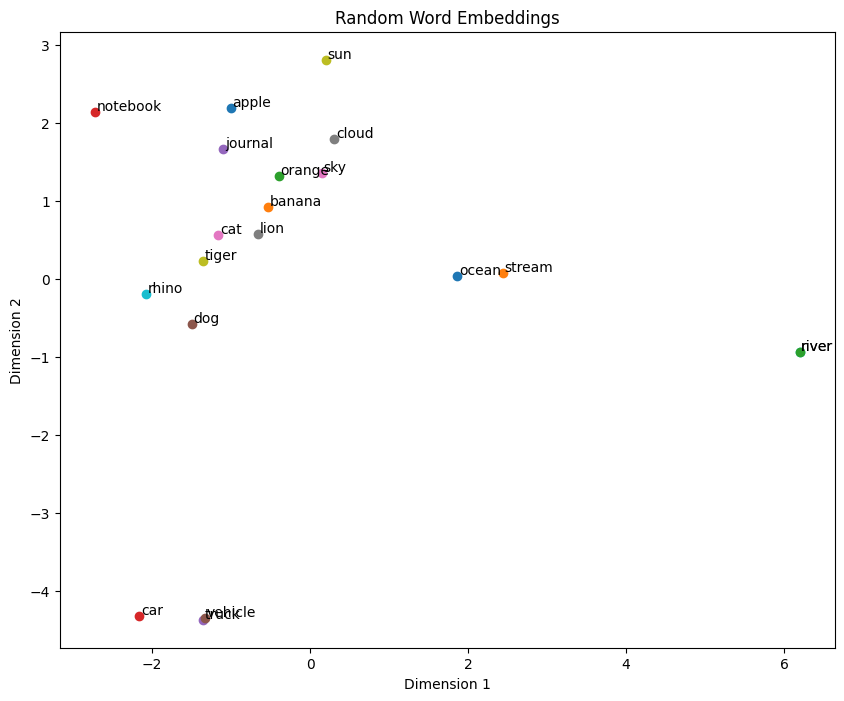

In [60]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def reduce_dimensionality(embeddings):
    pca = PCA(n_components=2)
    return pca.fit_transform(embeddings)


def plot_embeddings(reduced_embeddings, words):
    plt.figure(figsize=(10, 8))
    for i, word in enumerate(words):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
        plt.text(reduced_embeddings[i, 0] + 0.02, reduced_embeddings[i, 1] + 0.02, word, fontsize=10)
    plt.title("Random Word Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


def main_method():
    #random_words = random.sample(list(wv_from_bin.key_to_index.keys()), 20)
    random_words = ["apple", "banana", "orange", "car", "truck", "vehicle", "sky", "cloud", "sun", "river",
                "ocean", "stream", "river", "notebook", "journal", "dog", "cat", "lion", "tiger", "rhino"]
    embeddings = np.array([wv_from_bin[word] for word in random_words])
    reduced_embeddings = reduce_dimensionality(embeddings)
    plot_embeddings(reduced_embeddings, random_words)
main_method()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

__Synonyms and antonyms:__ Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful".

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. _(5 points)_

In [61]:
w1="fast"
w2="quick"
w3="slow"
cos_dist_w1_w2 = wv_from_bin.distance(w1, w2)
cos_dist_w1_w3 = wv_from_bin.distance(w1, w3)
print(f"Cosine Distance({w1}, {w2}) : {cos_dist_w1_w2}")
print(f"Cosine Distance({w1}, {w3}) : {cos_dist_w1_w3}")

Cosine Distance(fast, quick) : 0.3328641653060913
Cosine Distance(fast, slow) : 0.2522680163383484


Fast and Quick are synonyms, but the cosine distance between their word embeddings is larger than the cosine distance between Fast and Slow. This is mainly because antonyms may appear ofter in contexts. Identical contexts are found seldom, than in comparision with opposite contexts which explains the larger cosine distance.

<!-- END QUESTION -->

__Finding analogies:__ Implement a function `analogy()` which solves the analogy problem, e.g., `man:king::woman:x`. Use the `most_similar()` function provided in Gensim for your implementation. _(3 points)_

In [62]:
def analogy(x1: str, x2: str, y1: str, top_k: int = 1) -> List[Tuple[str, float]]:
    """Solves for x1:x2::y1:?
    Returns the top-k similar ones.
    """
    # YOUR CODE HERE
    result = wv_from_bin.most_similar(positive=[x2, y1], negative=[x1], topn=top_k)
    return result

In [63]:
grader.check("word2vec-analogy-impl")

word2vec-analogy-impl results: All test cases passed!

<!-- BEGIN QUESTION -->

__Analyzing bias:__ Complete the following analogies: `man:worker::woman:x` and `woman:worker::man:x` and list the most likely outputs in both cases. Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias. _(5 points)_

__Answer:__

In the analogy man:worker::woman:x, the results often give words like nurse, pregnant, mother for women. But in woman:worker::man:x, the results give words like employee, working, labourer for men. This shows a cultural bias where men are linked more with jobs of influence, while women are linked with family or care roles. Word embeddings learn from large text sources and pick up these patterns, including stereotypes. When used in real systems like hiring or recommendations, such bias can cause serious problems.

In [64]:
# Your code here
analogy_result_1 = analogy("man", "worker", "woman", top_k=5)
analogy_result_2 = analogy("woman", "worker", "man", top_k=5)

print("Analogy (man:worker :: woman: ?):", analogy_result_1)
print("Analogy (woman:worker :: man: ?):", analogy_result_2)

Analogy (man:worker :: woman: ?): [('employee', 0.6375863552093506), ('workers', 0.6068920493125916), ('nurse', 0.5837947130203247), ('pregnant', 0.5363885164260864), ('mother', 0.5321308970451355)]
Analogy (woman:worker :: man: ?): [('workers', 0.611325740814209), ('employee', 0.5983108878135681), ('working', 0.5615329742431641), ('laborer', 0.5442320108413696), ('unemployed', 0.536851704120636)]


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

__Question:__ Suggest some ways to deal with the gender (or racial) bias when training word embedding models, or when using pre-trained models. _(5 points)_

__Answer:__

We can reduce bias by using training datasets that fairly represent different genders, races, and groups, and by showing both men and women in all kinds of jobs. Another way is to fine-tune pre-trained embeddings with balanced datasets, making sure male and female pronouns appear equally with different occupations. Finally, we can change the loss function so the model is penalized more when it links a gender too strongly with certain jobs.

<!-- END QUESTION -->

